In [16]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
import heapq
import random
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import time

Step 1: Load the dataset

In [2]:
df = pd.read_csv("../datasets/adult.csv")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
df.shape, df.columns

((48842, 15),
 Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
        'marital-status', 'occupation', 'relationship', 'race', 'gender',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
        'income'],
       dtype='object'))

In [4]:
df["income"].value_counts() # Target

income
<=50K    37155
>50K     11687
Name: count, dtype: int64

In [5]:
df["gender"].value_counts() # Sensitive Attr

gender
Male      32650
Female    16192
Name: count, dtype: int64

Pre-process columns:
* Categorical
* Scale

Remove sensitive attribute.

In [6]:
le = LabelEncoder()

adult_columns = ["workclass", 
           "education", 
           "marital-status", 
           "occupation", 
           "relationship", 
           "race", 
           "gender", 
           "native-country", 
           "income"]
# adults_drop = ["gender", "index"]
adults_drop = ["gender", "income"]

for col in adult_columns:
    df[col] = le.fit_transform(df[col])

s = df["gender"]
X = df.drop(columns=adults_drop)
y = df["income"]

X.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country
0,25,4,226802,1,7,4,7,3,2,0,0,40,39
1,38,4,89814,11,9,2,5,0,4,0,0,50,39
2,28,2,336951,7,12,2,11,0,4,0,0,40,39
3,44,4,160323,15,10,2,7,0,2,7688,0,40,39
4,18,0,103497,15,10,4,0,3,4,0,0,30,39


In [ ]:
X = StandardScaler().fit_transform(X)
X.shape, y.shape

((48842, 13), (48842,))

Train a classifier on the dataset. This is the same as black-box model in the paper.

In [8]:
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X, y, indices, test_size=0.33, random_state=0, shuffle=True, )
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

0.8200148901848865

Sort the points based on the accuracy of the classifier

In [9]:
scores = clf.predict_proba(X_test)[list(y_test.reset_index().index), y_test.to_list()]
scores.shape

(16118,)

In [10]:
BOTTOM_K_ERROR_REGION = 0.2 # The ratio of error region
ratio = int(BOTTOM_K_ERROR_REGION * len(scores))
err_region_ind = np.argpartition(scores, ratio)[:ratio]
err_region = scores[err_region_ind]
err_region.shape, scores.shape

((3223,), (16118,))

Visualize the error region in 2D

Text(0.5, 1.0, 'Demographic groups (Yellow is minority)')

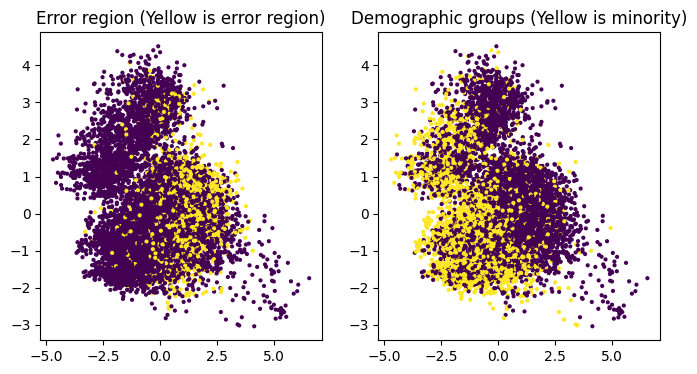

In [11]:
pca = PCA(n_components=2)
x_test_reduced = pca.fit_transform(X_test)
y_test_reduced = np.zeros(y_test.shape)
y_test_reduced[err_region_ind] = 1
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(x=x_test_reduced[:, 0], y=x_test_reduced[:, 1], c=y_test_reduced, s=4)
ax[0].set_title("Error region (Yellow is error region)")
ax[1].scatter(x=x_test_reduced[:, 0], y=x_test_reduced[:, 1], c=np.bitwise_not(s[ind_test]), s=4)
ax[1].set_title("Demographic groups (Yellow is minority)")

### Focused Exploration

In [12]:
err_region_one_hot = np.zeros(y_test.shape)
err_region_one_hot[err_region_ind] = 1
np.unique(err_region_one_hot, return_counts=True)

(array([0., 1.]), array([12895,  3223]))

Approach

* Sample from the test data
* For each pair of points (a, b) in this sample, where a \in err_region and b \notin err_region calc skew
* Report highest skews

In [13]:
def skew(f, points):
    p_f = np.dot(points, f)
    mean = np.mean(p_f)
    sd = np.std(p_f)
    median = np.median(p_f)
    return ((mean - median) / sd)

def get_line(first_point, second_point):
    vec = second_point - first_point
    v_hat = vec / np.linalg.norm(vec)
    return v_hat

In [14]:
TEST_SAMPLE_RATIO = 0.05
X_test.shape, err_region_one_hot.shape

((16118, 13), (16118,))

In [15]:
ind_sample = np.random.choice(len(X_test), size=int(len(X_test) * TEST_SAMPLE_RATIO), replace=False)
sample_test = X_test[ind_sample]
sample_err = err_region_one_hot[ind_sample]
sample_test.shape, sample_err.shape, np.unique(sample_err, return_counts=True)

((805, 13), (805,), (array([0., 1.]), array([635, 170])))

In [17]:
err_reg_portion = sample_test[sample_err == 1]
not_err_reg_portion = sample_test[sample_err == 0]

heap = []
counter = 0
MAX = len(err_reg_portion)

start = time.time()

for a in err_reg_portion:
    counter += 1
    print(f"{counter} / {MAX}")
    for b in not_err_reg_portion:
        f = get_line(a, b)
        sk = skew(f, X_train)
        heapq.heappush(heap, (-sk, tuple(f)))

end = time.time()
print("Time:", end - start)

1 / 170
2 / 170
3 / 170
4 / 170
5 / 170
6 / 170
7 / 170
8 / 170
9 / 170
10 / 170
11 / 170
12 / 170
13 / 170
14 / 170
15 / 170
16 / 170
17 / 170
18 / 170
19 / 170
20 / 170
21 / 170
22 / 170
23 / 170
24 / 170
25 / 170
26 / 170
27 / 170
28 / 170
29 / 170
30 / 170
31 / 170
32 / 170
33 / 170
34 / 170
35 / 170
36 / 170
37 / 170
38 / 170
39 / 170
40 / 170
41 / 170
42 / 170
43 / 170
44 / 170
45 / 170
46 / 170
47 / 170
48 / 170
49 / 170
50 / 170
51 / 170
52 / 170
53 / 170
54 / 170
55 / 170
56 / 170
57 / 170
58 / 170
59 / 170
60 / 170
61 / 170
62 / 170
63 / 170
64 / 170
65 / 170
66 / 170
67 / 170
68 / 170
69 / 170
70 / 170
71 / 170
72 / 170
73 / 170
74 / 170
75 / 170
76 / 170
77 / 170
78 / 170
79 / 170
80 / 170
81 / 170
82 / 170
83 / 170
84 / 170
85 / 170
86 / 170
87 / 170
88 / 170
89 / 170
90 / 170
91 / 170
92 / 170
93 / 170
94 / 170
95 / 170
96 / 170
97 / 170
98 / 170
99 / 170
100 / 170
101 / 170
102 / 170
103 / 170
104 / 170
105 / 170
106 / 170
107 / 170
108 / 170
109 / 170
110 / 170
111 / 17

In [17]:
def get_high_skews(heap, top_k=10):
        count = 0
        heap = heap.copy()
        while True:
            count = count + 1
            try:
                yield heapq.heappop(heap)
                if count == top_k:
                    break
            except:
                break

top_skews = list(get_high_skews(heap, top_k=5))

Visualize high skewed directions

In [18]:
gender = s[ind_train]

In [19]:
gender.value_counts()

gender
1    21918
0    10806
Name: count, dtype: int64

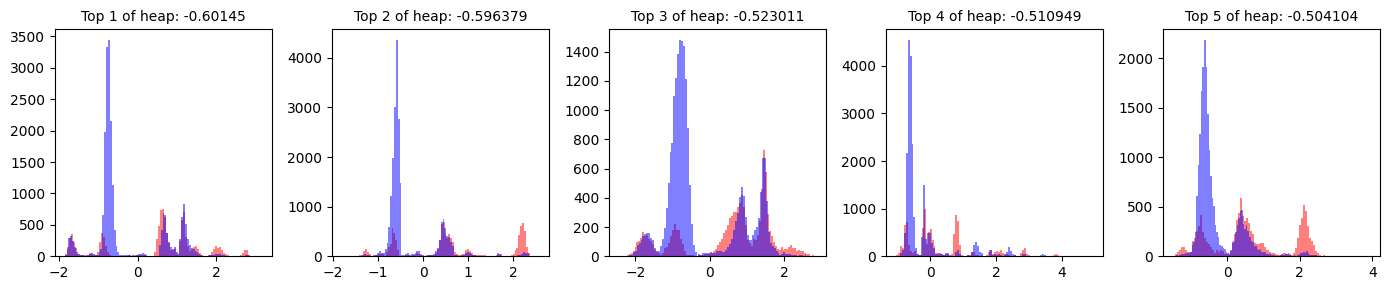

In [20]:
fig, axs = plt.subplots(1, len(top_skews), figsize=(14, 3))
ind = 0
for ax in axs:
    ax.hist(np.dot(X_train[gender == 0], top_skews[ind][1]), color="red", alpha=0.5, bins=100, label="Female")
    ax.hist(np.dot(X_train[gender != 0], top_skews[ind][1]), color="blue", alpha=0.5, bins=100, label="Male")
    ax.set_title(f"Top {ind + 1} of heap: {round(top_skews[ind][0], 6)}", fontsize=10)
    ind += 1
plt.tight_layout()

Report problematic points from the tail.

* Given a percentile as hyper-parameter, find the tail on X_train
* Among the points on the tail, report the most problematic ones

In [21]:
TAIL_PERCENTILE = 0.01 # Percentile of points as tail
SCORE_RATIO = 0.05 # Error region ratio in X_train

In [22]:
def get_demo_ratio(arr, min):
    uniq, counts = np.unique(arr, return_counts=True)

    min_count = 0
    try:
        min_count = counts[uniq == min][0]
    except:
        pass

    maj_count = 0
    try:
        maj_count = np.sum(counts)
    except:
        pass

    return min_count / max(maj_count, 0.1)

In [ ]:
results = {
    "top_skew": [], # Which highest skew (1st, 2nd, ...)
    "total_demo_ratio": [], # Demographic ratio of minorities
    "tail_demo_ratio": [], # Demographic ratio of minorities on the tail
    "tail_percentile": [], # The percentile used as tail
    "min_avg_tail_score": [], # Average score of minorities on tail
    "maj_avg_tail_score": [], # Average score of majoroties on tail
    "total_avg_tail_score": [], # Score on the tail of direction
    "score_ratio": [], # k: Top-K errors on the tail to report as the problematic points
    "tail_err_demo_ratio": [] # Ratio of demographic groups in the problematic points of the tail
}

min_label = 0

counter = 0
for (_, f) in top_skews:
    print(f"Highest {counter + 1} skew")
    counter += 1

    tmp = np.dot(X_train, f)
    sk = (np.mean(tmp) - np.median(tmp)) / np.std(tmp)

    q1 = np.quantile(tmp, TAIL_PERCENTILE if sk < 0 else (1 - TAIL_PERCENTILE))
    tail_ind = np.apply_along_axis(lambda r: np.dot(r, f) < q1 if sk < 0 else np.dot(r, f) > q1, 1, X_train)
    tail = X_train[tail_ind]

    print("Tail demographics: ")
    print(pd.DataFrame(gender[tail_ind]).value_counts())
    print("Over all demographics: ")
    print(gender.value_counts())

    fem_tail = X_train[tail_ind][gender[tail_ind] == min_label]
    ml_tail = X_train[tail_ind][gender[tail_ind] != min_label]

    
    fem_scores = clf.predict_proba(fem_tail)[list(y_train[tail_ind][gender[tail_ind] == min_label].reset_index().index), y_train[tail_ind][gender[tail_ind] == min_label].to_list()] if fem_tail.shape[0] > 0 else 0
    ml_scores = clf.predict_proba(ml_tail)[list(y_train[tail_ind][gender[tail_ind] != min_label].reset_index().index), y_train[tail_ind][gender[tail_ind] != min_label].to_list()] if ml_tail.shape[0] > 0 else 0
    scores = clf.predict_proba(X_train[tail_ind])[list(y_train[tail_ind].reset_index().index), y_train[tail_ind].to_list()]

    print("Fem average score in tail: ", np.mean(fem_scores))
    print("Male average score in tail: ", np.mean(ml_scores))
    print("Total Tail Score: ", np.mean(scores))

    for sr in [0.8, 0.5, 0.2, 0.1, 0.05, 0.01]:
        print("Score Ratio: ", sr)

        scores = clf.predict_proba(X_train[tail_ind])[list(y_train[tail_ind].reset_index().index), y_train[tail_ind].to_list()]
        ratio = int(sr * len(scores))
        err_region_ind = np.argpartition(scores, ratio)[:ratio]
        err_region = scores[err_region_ind]
        
        g = gender[tail_ind].to_numpy()[err_region_ind]
        print("Demographics in the error region:")
        print(pd.DataFrame(g).value_counts())

        results["top_skew"].append(counter)
        results["tail_demo_ratio"].append(get_demo_ratio(gender[tail_ind], min_label))
        results["total_demo_ratio"].append(get_demo_ratio(gender, min_label))
        results["tail_percentile"].append(TAIL_PERCENTILE)
        results["maj_avg_tail_score"].append(np.mean(ml_scores))
        results["min_avg_tail_score"].append(np.mean(fem_scores))
        results["total_avg_tail_score"].append(np.mean(scores))
        results["score_ratio"].append(sr)
        results["tail_err_demo_ratio"].append(get_demo_ratio(g, min_label))
        
        print("Results")
        for k in results:
            print(k, results[k][-1])


Persist the results

In [18]:
# pd.DataFrame(results).to_csv("./reports/adults_exp_1.csv")

Visualize Results

In [2]:
results = pd.read_csv("./reports/adults_exp_1.csv", index_col=0)
results.head()

,top_skew,total_demo_ratio,tail_demo_ratio,tail_percentile,min_avg_tail_score,maj_avg_tail_score,total_avg_tail_score,score_ratio,tail_err_demo_ratio
0,1,0.330216,0.844512,0.01,0.90945,0.823346,0.896062,0.80,0.847328
1,1,0.330216,0.844512,0.01,0.90945,0.823346,0.896062,0.50,0.835366
2,1,0.330216,0.844512,0.01,0.90945,0.823346,0.896062,0.20,0.753846
3,1,0.330216,0.844512,0.01,0.90945,0.823346,0.896062,0.10,0.625000
4,1,0.330216,0.844512,0.01,0.90945,0.823346,0.896062,0.05,0.750000


The ratio of minorities given different bottom k accuracies on tail.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


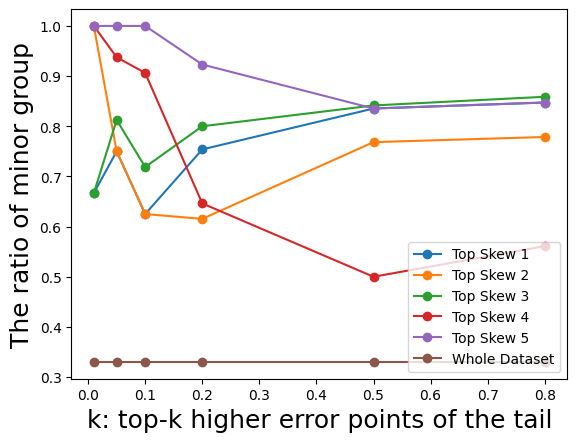

In [25]:
markers = ["o", "o", "o", "o", "o"]
for i in range(5):
    plt.plot(results[results["top_skew"] == i + 1]["score_ratio"], results[results["top_skew"] == i + 1]["tail_err_demo_ratio"], marker=markers[i], label=f"Top Skew {i + 1}")
plt.plot(results[results["top_skew"] == 1]["score_ratio"], results[results["top_skew"] == 1]["total_demo_ratio"], marker="o", label="Whole Dataset")
plt.ylabel("The ratio of minor group", fontsize=18)
plt.xlabel("k: top-k higher error points of the tail", fontsize=18)
plt.legend(fontsize=10, loc="lower right")
# plt.savefig("adults_region.eps", format="eps")

In [39]:
# Model score = 0.82
results.groupby("top_skew").mean()[["total_avg_tail_score", "min_avg_tail_score", "maj_avg_tail_score"]]

,total_avg_tail_score,min_avg_tail_score,maj_avg_tail_score
top_skew,,,
1,0.896062,0.909450,0.823346
2,0.813582,0.827329,0.763818
3,0.909436,0.916654,0.867330
4,0.780287,0.755071,0.813730
5,0.726513,0.715182,0.786654
